# Demo: Building Denoising Autoencoders in Pytorch (CIFAR10)

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Sources: 
<ol>
<li>Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.</li>
<li>Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.</li>
<li>Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.</li>
</ol>

In [1]:
!pip list | grep torch

torch                         2.0.1+cpu
torchaudio                    2.0.2+cpu
torchsummary                  1.5.1
torchvision                   0.15.2+cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir, train=False, download=True)

print('Training data shape:', train_dataset.data.shape)
print('Test data shape:', test_dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


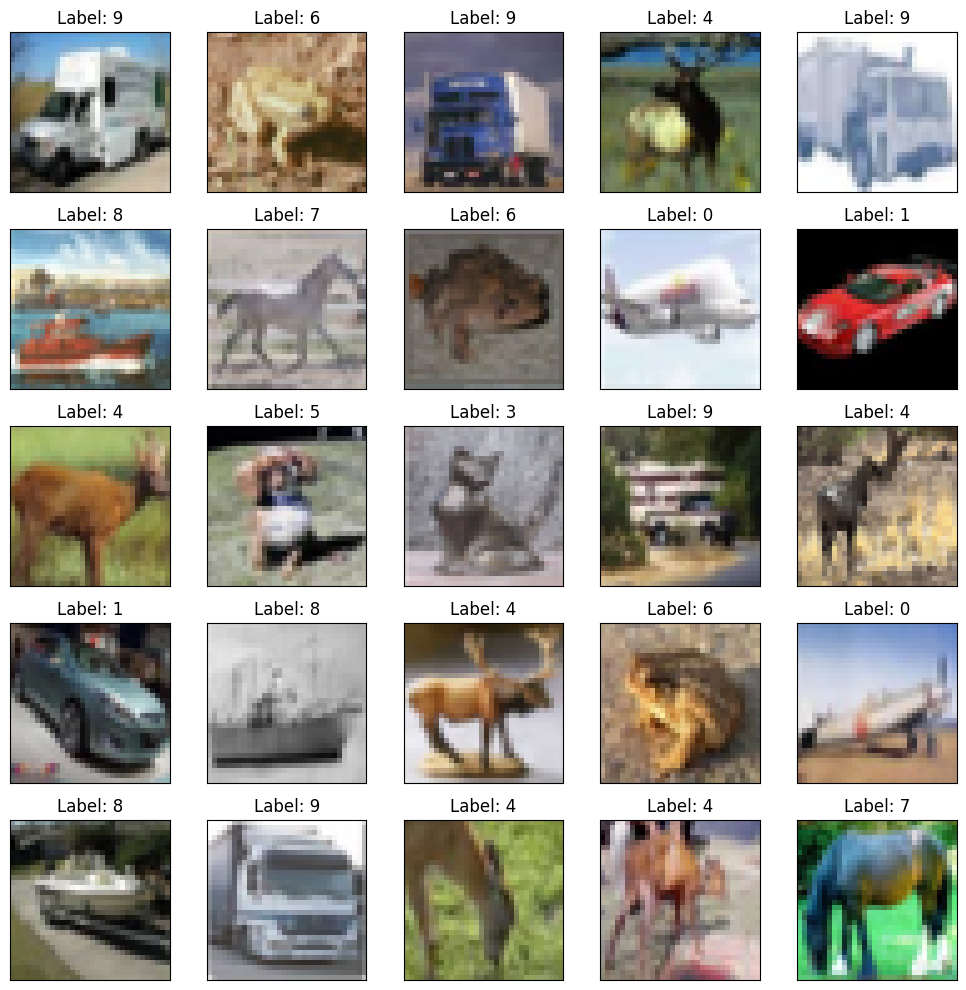

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img))
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [6]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1 Define Encoder and Decoder classes

In [7]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [8]:
# Images are (N, W, H)
B = batch_size                 # Batch size
N = test_dataset.data.shape[0] # Examples
W = test_dataset.data.shape[1] # Width
H = test_dataset.data.shape[2] # Height
C = test_dataset.data.shape[3] # Channels
BC = W                         # Base channels
D = W * H * C                  # Features
classes = 10                   # Label classes

# Input of shape (C, W)

# Filters of shape (C, K)
kernels = 12                   # Number of kernels
K = 3                          # Size of kernels
d = 256                        # Latent dimension

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## 2 initialize models, loss and optimizer
*Note that "d" is the size of a latent space*

In [11]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
# encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
encoder = Encoder(C, BC, d)
decoder = Decoder(C, BC, d)

In [12]:
summary(encoder, (C, W, H))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              GELU-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           9,248
              GELU-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              GELU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 4, 4]          36,928
             GELU-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 256]         262,400
Total params: 364,896
Trainable params: 364,896
Non-trainable params: 0
-------------------------------

In [13]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
print(encoder)
print(decoder)

Selected device: cpu
Encoder(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=256, bias=True)
  )
)
Decoder(
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): GELU(approximate='none')
  )
  (net): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='non

## 3 Train model

In [14]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[ 1.0375, -0.0116,  0.7286,  ..., -0.0842,  0.0397, -0.1588],
          [ 0.2882,  0.3894,  0.4410,  ...,  0.7752,  0.7680,  0.1383],
          [ 0.6423,  0.8301,  0.5576,  ...,  0.8912,  0.3900,  0.5280],
          ...,
          [-0.1048,  0.3528,  0.4401,  ...,  0.0363,  0.0886,  0.1694],
          [ 0.2688,  0.3059, -0.2780,  ...,  0.2084,  0.4330, -0.0546],
          [ 0.7676,  0.6820,  0.0276,  ..., -0.0169,  0.3940,  0.1158]],

         [[ 0.5710,  0.5936,  0.3155,  ..., -0.3224,  0.2479,  0.5240],
          [ 0.7533,  0.8610,  0.9392,  ...,  0.7438,  0.7241,  0.0382],
          [ 1.0142,  0.3999,  0.1086,  ...,  0.4331,  0.0145,  0.1561],
          ...,
          [ 0.1511,  0.0333,  0.3207,  ...,  0.2895,  0.2425,  0.4365],
          [ 0.3960,  0.5389,  0.5022,  ...,  0.7697,  0.0950,  0.3148],
          [ 0.3126,  0.0440,  0.0126,  ...,  0.6296,  0.3453,  0.1175]],

         [[-0.0458,  0.5102,  0.1012,  ...,  0.3878,  0.2135, -0.2497],
          [-0.3645,  0.3492, -

In [15]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[1.0000, 0.0000, 0.7286,  ..., 0.0000, 0.0397, 0.0000],
          [0.2882, 0.3894, 0.4410,  ..., 0.7752, 0.7680, 0.1383],
          [0.6423, 0.8301, 0.5576,  ..., 0.8912, 0.3900, 0.5280],
          ...,
          [0.0000, 0.3528, 0.4401,  ..., 0.0363, 0.0886, 0.1694],
          [0.2688, 0.3059, 0.0000,  ..., 0.2084, 0.4330, 0.0000],
          [0.7676, 0.6820, 0.0276,  ..., 0.0000, 0.3940, 0.1158]],

         [[0.5710, 0.5936, 0.3155,  ..., 0.0000, 0.2479, 0.5240],
          [0.7533, 0.8610, 0.9392,  ..., 0.7438, 0.7241, 0.0382],
          [1.0000, 0.3999, 0.1086,  ..., 0.4331, 0.0145, 0.1561],
          ...,
          [0.1511, 0.0333, 0.3207,  ..., 0.2895, 0.2425, 0.4365],
          [0.3960, 0.5389, 0.5022,  ..., 0.7697, 0.0950, 0.3148],
          [0.3126, 0.0440, 0.0126,  ..., 0.6296, 0.3453, 0.1175]],

         [[0.0000, 0.5102, 0.1012,  ..., 0.3878, 0.2135, 0.0000],
          [0.0000, 0.3492, 0.0000,  ..., 0.0058, 0.7263, 0.1949],
          [0.5656, 0.2348, 0.0000,  ..., 0

In [16]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [17]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader:
        
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        
        # Encode data
        encoded_data = encoder(image_noisy)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [18]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            
            # Encode data
            encoded_data = encoder(image_noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

**Note that image axes must have been incorrectly assigned in the process of its encoding and decoding, the correction was applied in image plotting**

In [19]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        img_sel = img.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(3, n, i + 1 + n)
        img_sel = image_noisy.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        img_sel = rec_img.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH 1/30
	 partial train loss (single batch): 0.231807
	 partial train loss (single batch): 0.235140
	 partial train loss (single batch): 0.220227
	 partial train loss (single batch): 0.226253
	 partial train loss (single batch): 0.219983
	 partial train loss (single batch): 0.208010
	 partial train loss (single batch): 0.208934
	 partial train loss (single batch): 0.204395
	 partial train loss (single batch): 0.194981
	 partial train loss (single batch): 0.172408
	 partial train loss (single batch): 0.164620
	 partial train loss (single batch): 0.167144
	 partial train loss (single batch): 0.152909
	 partial train loss (single batch): 0.150056
	 partial train loss (single batch): 0.144365
	 partial train loss (single batch): 0.145724
	 partial train loss (single batch): 0.137958
	 partial train loss (single batch): 0.131086
	 partial train loss (single batch): 0.123899
	 partial train loss (single batch): 0.119755
	 partial train loss (single batch): 0.117475
	 partial train loss (s

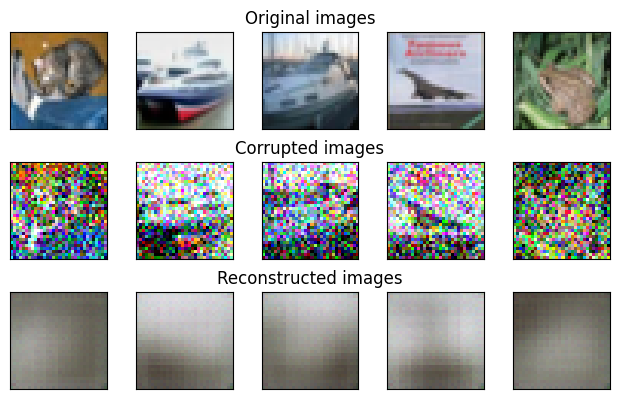

EPOCH 2/30
	 partial train loss (single batch): 0.080524
	 partial train loss (single batch): 0.081484
	 partial train loss (single batch): 0.081063
	 partial train loss (single batch): 0.081898
	 partial train loss (single batch): 0.081093
	 partial train loss (single batch): 0.081447
	 partial train loss (single batch): 0.081511
	 partial train loss (single batch): 0.080918
	 partial train loss (single batch): 0.081588
	 partial train loss (single batch): 0.081546
	 partial train loss (single batch): 0.081003
	 partial train loss (single batch): 0.081063
	 partial train loss (single batch): 0.082239
	 partial train loss (single batch): 0.081528
	 partial train loss (single batch): 0.081815
	 partial train loss (single batch): 0.080966
	 partial train loss (single batch): 0.080962
	 partial train loss (single batch): 0.081163
	 partial train loss (single batch): 0.080234
	 partial train loss (single batch): 0.080392
	 partial train loss (single batch): 0.081455
	 partial train loss (s

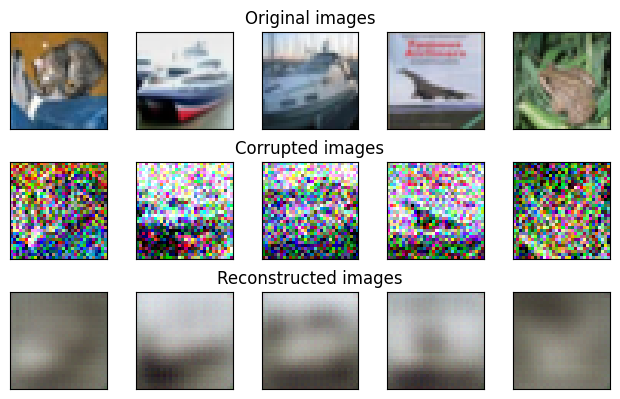

EPOCH 3/30
	 partial train loss (single batch): 0.075270
	 partial train loss (single batch): 0.076421
	 partial train loss (single batch): 0.075648
	 partial train loss (single batch): 0.076777
	 partial train loss (single batch): 0.075730
	 partial train loss (single batch): 0.076495
	 partial train loss (single batch): 0.076054
	 partial train loss (single batch): 0.076011
	 partial train loss (single batch): 0.076425
	 partial train loss (single batch): 0.076435
	 partial train loss (single batch): 0.075991
	 partial train loss (single batch): 0.076051
	 partial train loss (single batch): 0.076439
	 partial train loss (single batch): 0.076634
	 partial train loss (single batch): 0.076857
	 partial train loss (single batch): 0.075854
	 partial train loss (single batch): 0.075813
	 partial train loss (single batch): 0.076230
	 partial train loss (single batch): 0.076052
	 partial train loss (single batch): 0.076086
	 partial train loss (single batch): 0.076460
	 partial train loss (s

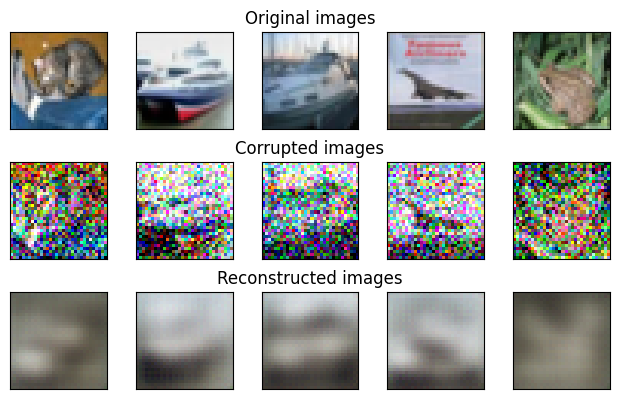

EPOCH 4/30
	 partial train loss (single batch): 0.073380
	 partial train loss (single batch): 0.074270
	 partial train loss (single batch): 0.073565
	 partial train loss (single batch): 0.074349
	 partial train loss (single batch): 0.073271
	 partial train loss (single batch): 0.074450
	 partial train loss (single batch): 0.074090
	 partial train loss (single batch): 0.073635
	 partial train loss (single batch): 0.074005
	 partial train loss (single batch): 0.074386
	 partial train loss (single batch): 0.073885
	 partial train loss (single batch): 0.074160
	 partial train loss (single batch): 0.074198
	 partial train loss (single batch): 0.074435
	 partial train loss (single batch): 0.074784
	 partial train loss (single batch): 0.073618
	 partial train loss (single batch): 0.073667
	 partial train loss (single batch): 0.073984
	 partial train loss (single batch): 0.073907
	 partial train loss (single batch): 0.074004
	 partial train loss (single batch): 0.074514
	 partial train loss (s

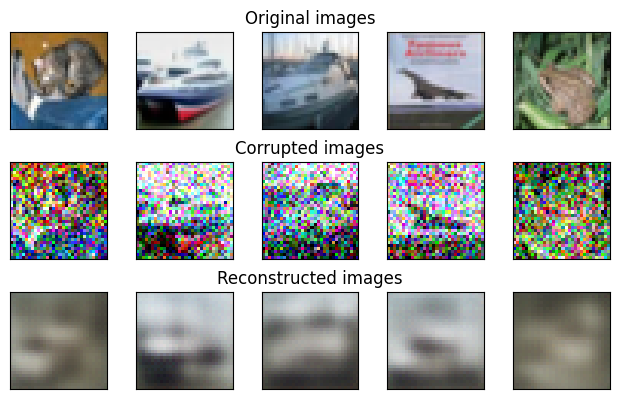

EPOCH 5/30
	 partial train loss (single batch): 0.072258
	 partial train loss (single batch): 0.072938
	 partial train loss (single batch): 0.072373
	 partial train loss (single batch): 0.073302
	 partial train loss (single batch): 0.072867
	 partial train loss (single batch): 0.074041
	 partial train loss (single batch): 0.073661
	 partial train loss (single batch): 0.072806
	 partial train loss (single batch): 0.072782
	 partial train loss (single batch): 0.073408
	 partial train loss (single batch): 0.072883
	 partial train loss (single batch): 0.073039
	 partial train loss (single batch): 0.073170
	 partial train loss (single batch): 0.073037
	 partial train loss (single batch): 0.073485
	 partial train loss (single batch): 0.072619
	 partial train loss (single batch): 0.072587
	 partial train loss (single batch): 0.072369
	 partial train loss (single batch): 0.072705
	 partial train loss (single batch): 0.072910
	 partial train loss (single batch): 0.073102
	 partial train loss (s

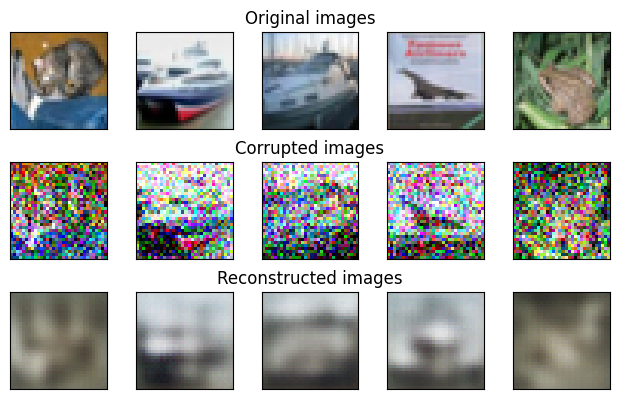

EPOCH 6/30
	 partial train loss (single batch): 0.071249
	 partial train loss (single batch): 0.071717
	 partial train loss (single batch): 0.071230
	 partial train loss (single batch): 0.071595
	 partial train loss (single batch): 0.070931
	 partial train loss (single batch): 0.071827
	 partial train loss (single batch): 0.071768
	 partial train loss (single batch): 0.071357
	 partial train loss (single batch): 0.071677
	 partial train loss (single batch): 0.071944
	 partial train loss (single batch): 0.071782
	 partial train loss (single batch): 0.071653
	 partial train loss (single batch): 0.072072
	 partial train loss (single batch): 0.072093
	 partial train loss (single batch): 0.072460
	 partial train loss (single batch): 0.071390
	 partial train loss (single batch): 0.071466
	 partial train loss (single batch): 0.071337
	 partial train loss (single batch): 0.071703
	 partial train loss (single batch): 0.071857
	 partial train loss (single batch): 0.072141
	 partial train loss (s

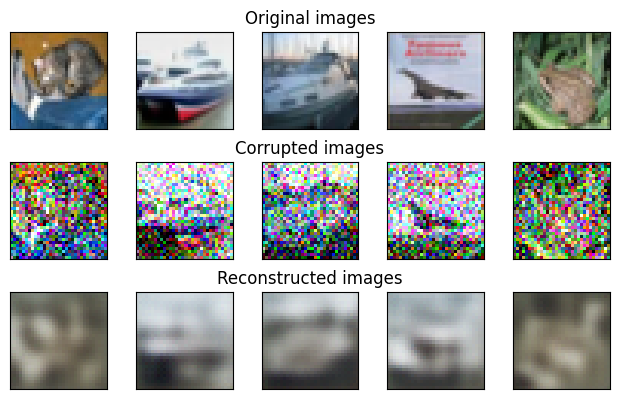

EPOCH 7/30
	 partial train loss (single batch): 0.070570
	 partial train loss (single batch): 0.071088
	 partial train loss (single batch): 0.070437
	 partial train loss (single batch): 0.071056
	 partial train loss (single batch): 0.070294
	 partial train loss (single batch): 0.071337
	 partial train loss (single batch): 0.071150
	 partial train loss (single batch): 0.070777
	 partial train loss (single batch): 0.071121
	 partial train loss (single batch): 0.071291
	 partial train loss (single batch): 0.070930
	 partial train loss (single batch): 0.070760
	 partial train loss (single batch): 0.071101
	 partial train loss (single batch): 0.071537
	 partial train loss (single batch): 0.071750
	 partial train loss (single batch): 0.070626
	 partial train loss (single batch): 0.070888
	 partial train loss (single batch): 0.070659
	 partial train loss (single batch): 0.071063
	 partial train loss (single batch): 0.071291
	 partial train loss (single batch): 0.071404
	 partial train loss (s

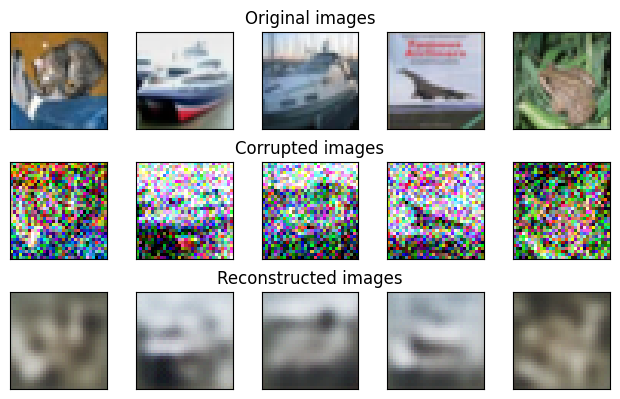

EPOCH 8/30
	 partial train loss (single batch): 0.070047
	 partial train loss (single batch): 0.070691
	 partial train loss (single batch): 0.070010
	 partial train loss (single batch): 0.070586
	 partial train loss (single batch): 0.069724
	 partial train loss (single batch): 0.070897
	 partial train loss (single batch): 0.070655
	 partial train loss (single batch): 0.070275
	 partial train loss (single batch): 0.070596
	 partial train loss (single batch): 0.070816
	 partial train loss (single batch): 0.070681
	 partial train loss (single batch): 0.070421
	 partial train loss (single batch): 0.070643
	 partial train loss (single batch): 0.071135
	 partial train loss (single batch): 0.071415
	 partial train loss (single batch): 0.070020
	 partial train loss (single batch): 0.070102
	 partial train loss (single batch): 0.070246
	 partial train loss (single batch): 0.070609
	 partial train loss (single batch): 0.070818
	 partial train loss (single batch): 0.071248
	 partial train loss (s

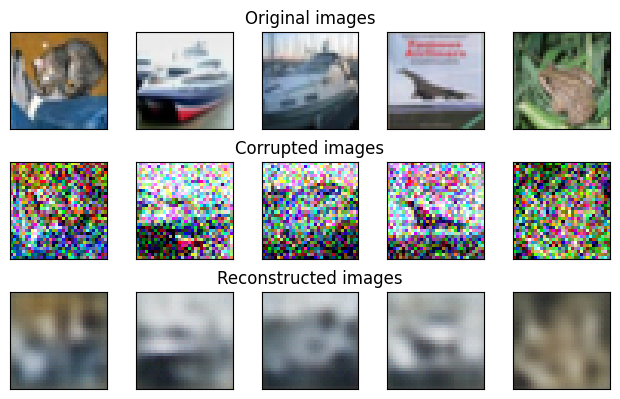

EPOCH 9/30
	 partial train loss (single batch): 0.068220
	 partial train loss (single batch): 0.068786
	 partial train loss (single batch): 0.068647
	 partial train loss (single batch): 0.069310
	 partial train loss (single batch): 0.068380
	 partial train loss (single batch): 0.069180
	 partial train loss (single batch): 0.068622
	 partial train loss (single batch): 0.068503
	 partial train loss (single batch): 0.068908
	 partial train loss (single batch): 0.069506
	 partial train loss (single batch): 0.068847
	 partial train loss (single batch): 0.068566
	 partial train loss (single batch): 0.068908
	 partial train loss (single batch): 0.069170
	 partial train loss (single batch): 0.069577
	 partial train loss (single batch): 0.068419
	 partial train loss (single batch): 0.068145
	 partial train loss (single batch): 0.068306
	 partial train loss (single batch): 0.069084
	 partial train loss (single batch): 0.068856
	 partial train loss (single batch): 0.068578
	 partial train loss (s

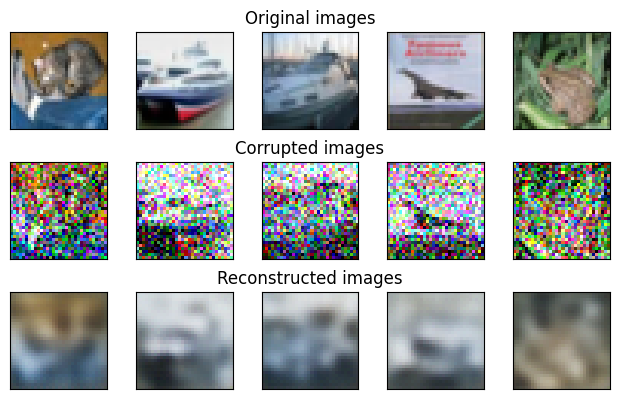

EPOCH 10/30
	 partial train loss (single batch): 0.067652
	 partial train loss (single batch): 0.067916
	 partial train loss (single batch): 0.067680
	 partial train loss (single batch): 0.068164
	 partial train loss (single batch): 0.067557
	 partial train loss (single batch): 0.068675
	 partial train loss (single batch): 0.067975
	 partial train loss (single batch): 0.067879
	 partial train loss (single batch): 0.068206
	 partial train loss (single batch): 0.068652
	 partial train loss (single batch): 0.068195
	 partial train loss (single batch): 0.068001
	 partial train loss (single batch): 0.068170
	 partial train loss (single batch): 0.068368
	 partial train loss (single batch): 0.068861
	 partial train loss (single batch): 0.067549
	 partial train loss (single batch): 0.067843
	 partial train loss (single batch): 0.067728
	 partial train loss (single batch): 0.068108
	 partial train loss (single batch): 0.068106
	 partial train loss (single batch): 0.068103
	 partial train loss (

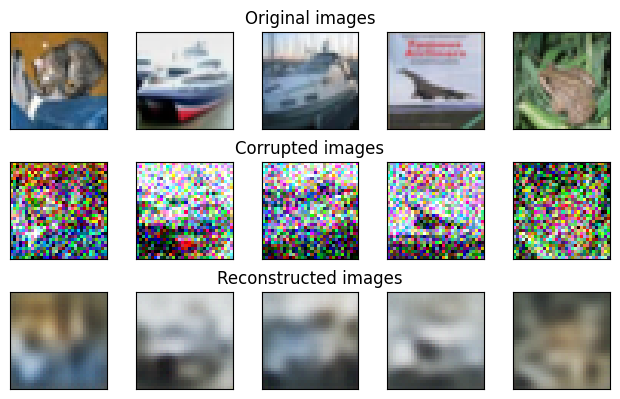

EPOCH 11/30
	 partial train loss (single batch): 0.067272
	 partial train loss (single batch): 0.067602
	 partial train loss (single batch): 0.067153
	 partial train loss (single batch): 0.067953
	 partial train loss (single batch): 0.067169
	 partial train loss (single batch): 0.068153
	 partial train loss (single batch): 0.067755
	 partial train loss (single batch): 0.067577
	 partial train loss (single batch): 0.067877
	 partial train loss (single batch): 0.068356
	 partial train loss (single batch): 0.067954
	 partial train loss (single batch): 0.067791
	 partial train loss (single batch): 0.068037
	 partial train loss (single batch): 0.068156
	 partial train loss (single batch): 0.068639
	 partial train loss (single batch): 0.067277
	 partial train loss (single batch): 0.067672
	 partial train loss (single batch): 0.067504
	 partial train loss (single batch): 0.068007
	 partial train loss (single batch): 0.067946
	 partial train loss (single batch): 0.067821
	 partial train loss (

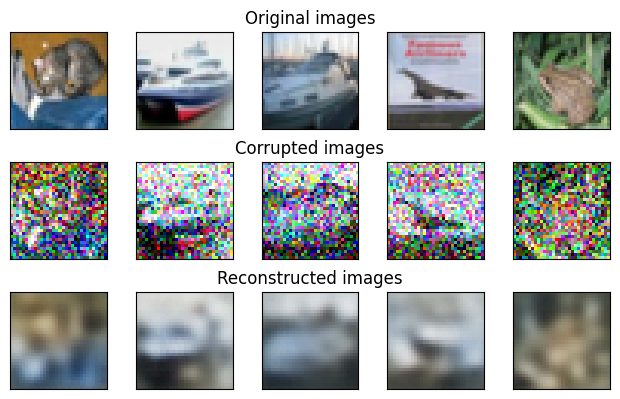

EPOCH 12/30
	 partial train loss (single batch): 0.066936
	 partial train loss (single batch): 0.067214
	 partial train loss (single batch): 0.066943
	 partial train loss (single batch): 0.067707
	 partial train loss (single batch): 0.067015
	 partial train loss (single batch): 0.068010
	 partial train loss (single batch): 0.067543
	 partial train loss (single batch): 0.067503
	 partial train loss (single batch): 0.067758
	 partial train loss (single batch): 0.068150
	 partial train loss (single batch): 0.067754
	 partial train loss (single batch): 0.067552
	 partial train loss (single batch): 0.067798
	 partial train loss (single batch): 0.067956
	 partial train loss (single batch): 0.068418
	 partial train loss (single batch): 0.066858
	 partial train loss (single batch): 0.067376
	 partial train loss (single batch): 0.067241
	 partial train loss (single batch): 0.067865
	 partial train loss (single batch): 0.067583
	 partial train loss (single batch): 0.067515
	 partial train loss (

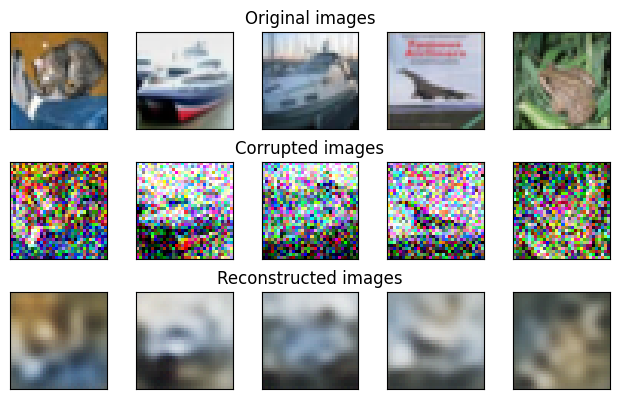

EPOCH 13/30
	 partial train loss (single batch): 0.066801
	 partial train loss (single batch): 0.067127
	 partial train loss (single batch): 0.066759
	 partial train loss (single batch): 0.067498
	 partial train loss (single batch): 0.066935
	 partial train loss (single batch): 0.067888
	 partial train loss (single batch): 0.067371
	 partial train loss (single batch): 0.067141
	 partial train loss (single batch): 0.067506
	 partial train loss (single batch): 0.067945
	 partial train loss (single batch): 0.067546
	 partial train loss (single batch): 0.067179
	 partial train loss (single batch): 0.067415
	 partial train loss (single batch): 0.067641
	 partial train loss (single batch): 0.067925
	 partial train loss (single batch): 0.066780
	 partial train loss (single batch): 0.067160
	 partial train loss (single batch): 0.066782
	 partial train loss (single batch): 0.067410
	 partial train loss (single batch): 0.067463
	 partial train loss (single batch): 0.067131
	 partial train loss (

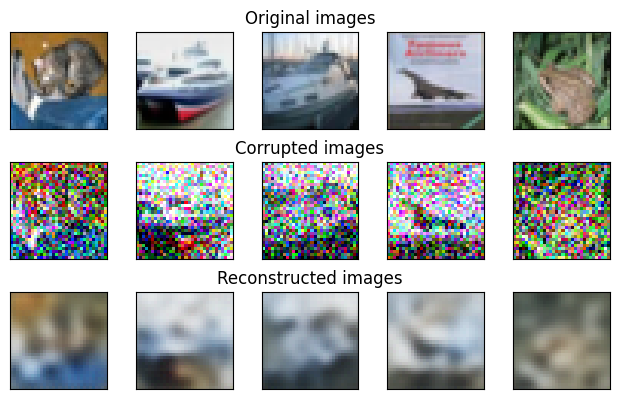

EPOCH 14/30
	 partial train loss (single batch): 0.066850
	 partial train loss (single batch): 0.067082
	 partial train loss (single batch): 0.066849
	 partial train loss (single batch): 0.067580
	 partial train loss (single batch): 0.066715
	 partial train loss (single batch): 0.067362
	 partial train loss (single batch): 0.067275
	 partial train loss (single batch): 0.066963
	 partial train loss (single batch): 0.067071
	 partial train loss (single batch): 0.067502
	 partial train loss (single batch): 0.067239
	 partial train loss (single batch): 0.067278
	 partial train loss (single batch): 0.067332
	 partial train loss (single batch): 0.067536
	 partial train loss (single batch): 0.067678
	 partial train loss (single batch): 0.066426
	 partial train loss (single batch): 0.066884
	 partial train loss (single batch): 0.066619
	 partial train loss (single batch): 0.067353
	 partial train loss (single batch): 0.067321
	 partial train loss (single batch): 0.067148
	 partial train loss (

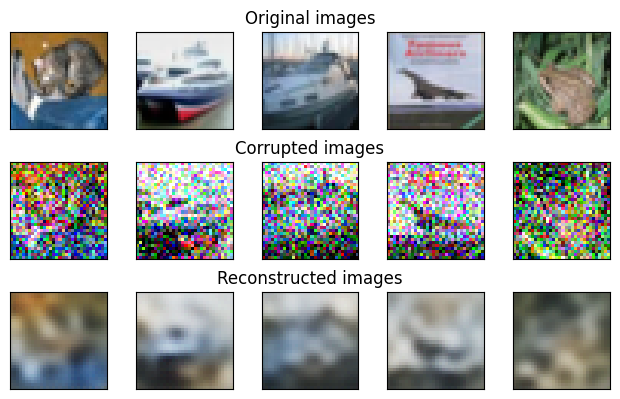

EPOCH 15/30
	 partial train loss (single batch): 0.066320
	 partial train loss (single batch): 0.066760
	 partial train loss (single batch): 0.066766
	 partial train loss (single batch): 0.067533
	 partial train loss (single batch): 0.067479
	 partial train loss (single batch): 0.068057
	 partial train loss (single batch): 0.067692
	 partial train loss (single batch): 0.067034
	 partial train loss (single batch): 0.067057
	 partial train loss (single batch): 0.067775
	 partial train loss (single batch): 0.067456
	 partial train loss (single batch): 0.067141
	 partial train loss (single batch): 0.067205
	 partial train loss (single batch): 0.067486
	 partial train loss (single batch): 0.067822
	 partial train loss (single batch): 0.066061
	 partial train loss (single batch): 0.066869
	 partial train loss (single batch): 0.066868
	 partial train loss (single batch): 0.067182
	 partial train loss (single batch): 0.067036
	 partial train loss (single batch): 0.066816
	 partial train loss (

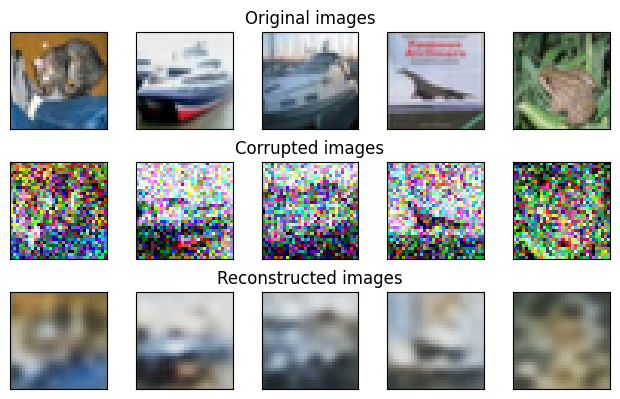

EPOCH 16/30
	 partial train loss (single batch): 0.065986
	 partial train loss (single batch): 0.066467
	 partial train loss (single batch): 0.066324
	 partial train loss (single batch): 0.067488
	 partial train loss (single batch): 0.067106
	 partial train loss (single batch): 0.068515
	 partial train loss (single batch): 0.066952
	 partial train loss (single batch): 0.066301
	 partial train loss (single batch): 0.066725
	 partial train loss (single batch): 0.067353
	 partial train loss (single batch): 0.066979
	 partial train loss (single batch): 0.066580
	 partial train loss (single batch): 0.066878
	 partial train loss (single batch): 0.067269
	 partial train loss (single batch): 0.067247
	 partial train loss (single batch): 0.065744
	 partial train loss (single batch): 0.066463
	 partial train loss (single batch): 0.066093
	 partial train loss (single batch): 0.066963
	 partial train loss (single batch): 0.066739
	 partial train loss (single batch): 0.066244
	 partial train loss (

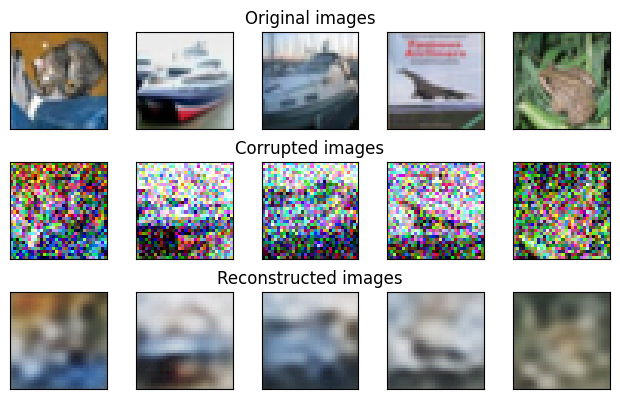

EPOCH 17/30
	 partial train loss (single batch): 0.065689
	 partial train loss (single batch): 0.065725
	 partial train loss (single batch): 0.065631
	 partial train loss (single batch): 0.066243
	 partial train loss (single batch): 0.065632
	 partial train loss (single batch): 0.066583
	 partial train loss (single batch): 0.066086
	 partial train loss (single batch): 0.066241
	 partial train loss (single batch): 0.066133
	 partial train loss (single batch): 0.066678
	 partial train loss (single batch): 0.066439
	 partial train loss (single batch): 0.066247
	 partial train loss (single batch): 0.066324
	 partial train loss (single batch): 0.066427
	 partial train loss (single batch): 0.066908
	 partial train loss (single batch): 0.065436
	 partial train loss (single batch): 0.065949
	 partial train loss (single batch): 0.065524
	 partial train loss (single batch): 0.066235
	 partial train loss (single batch): 0.066041
	 partial train loss (single batch): 0.065896
	 partial train loss (

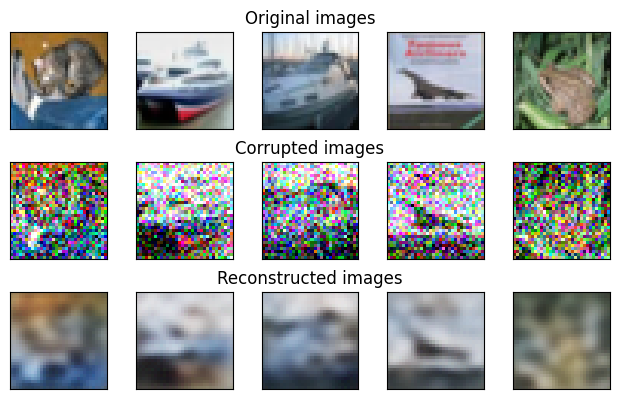

EPOCH 18/30
	 partial train loss (single batch): 0.065422
	 partial train loss (single batch): 0.065458
	 partial train loss (single batch): 0.065467
	 partial train loss (single batch): 0.066033
	 partial train loss (single batch): 0.065342
	 partial train loss (single batch): 0.066201
	 partial train loss (single batch): 0.065534
	 partial train loss (single batch): 0.065626
	 partial train loss (single batch): 0.065934
	 partial train loss (single batch): 0.066398
	 partial train loss (single batch): 0.065989
	 partial train loss (single batch): 0.065923
	 partial train loss (single batch): 0.065873
	 partial train loss (single batch): 0.066100
	 partial train loss (single batch): 0.066498
	 partial train loss (single batch): 0.065169
	 partial train loss (single batch): 0.065660
	 partial train loss (single batch): 0.065192
	 partial train loss (single batch): 0.066177
	 partial train loss (single batch): 0.065802
	 partial train loss (single batch): 0.065493
	 partial train loss (

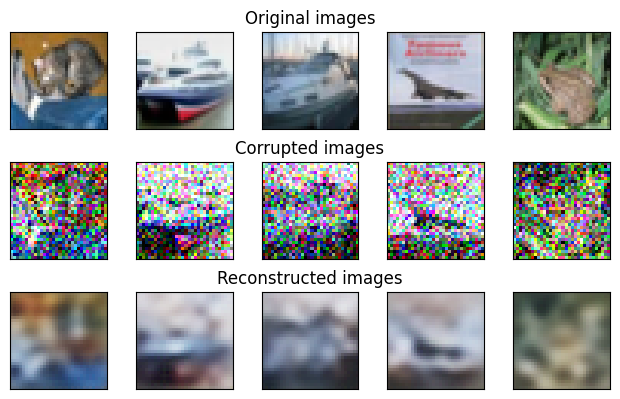

EPOCH 19/30
	 partial train loss (single batch): 0.065067
	 partial train loss (single batch): 0.065236
	 partial train loss (single batch): 0.064999
	 partial train loss (single batch): 0.065725
	 partial train loss (single batch): 0.064926
	 partial train loss (single batch): 0.065846
	 partial train loss (single batch): 0.065538
	 partial train loss (single batch): 0.065404
	 partial train loss (single batch): 0.065509
	 partial train loss (single batch): 0.065961
	 partial train loss (single batch): 0.065744
	 partial train loss (single batch): 0.065533
	 partial train loss (single batch): 0.065693
	 partial train loss (single batch): 0.065910
	 partial train loss (single batch): 0.066118
	 partial train loss (single batch): 0.065033
	 partial train loss (single batch): 0.065304
	 partial train loss (single batch): 0.065276
	 partial train loss (single batch): 0.066148
	 partial train loss (single batch): 0.066134
	 partial train loss (single batch): 0.065740
	 partial train loss (

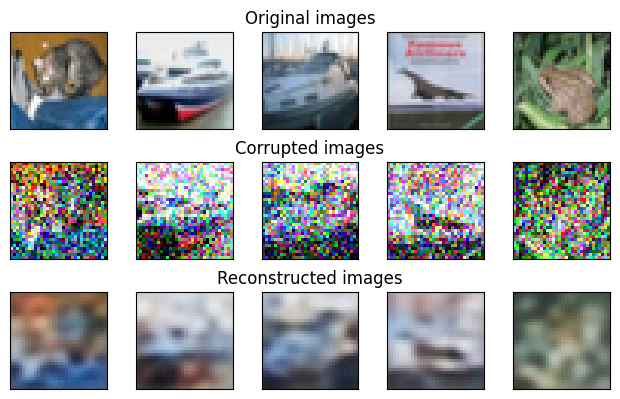

EPOCH 20/30
	 partial train loss (single batch): 0.065085
	 partial train loss (single batch): 0.064941
	 partial train loss (single batch): 0.064885
	 partial train loss (single batch): 0.065491
	 partial train loss (single batch): 0.065009
	 partial train loss (single batch): 0.065978
	 partial train loss (single batch): 0.065227
	 partial train loss (single batch): 0.065201
	 partial train loss (single batch): 0.065510
	 partial train loss (single batch): 0.065841
	 partial train loss (single batch): 0.065643
	 partial train loss (single batch): 0.065210
	 partial train loss (single batch): 0.065523
	 partial train loss (single batch): 0.065638
	 partial train loss (single batch): 0.066001
	 partial train loss (single batch): 0.064752
	 partial train loss (single batch): 0.064951
	 partial train loss (single batch): 0.064969
	 partial train loss (single batch): 0.065620
	 partial train loss (single batch): 0.065282
	 partial train loss (single batch): 0.064996
	 partial train loss (

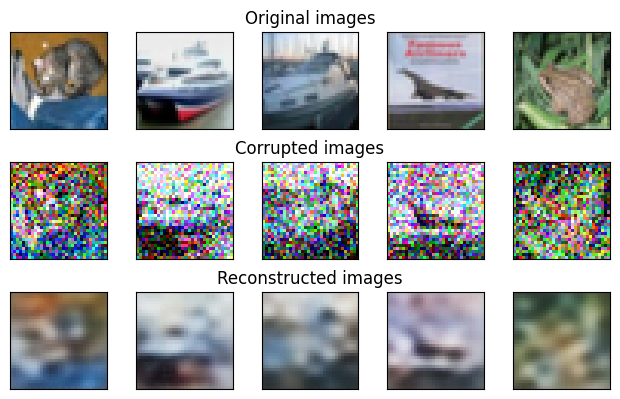

EPOCH 21/30
	 partial train loss (single batch): 0.064671
	 partial train loss (single batch): 0.064736
	 partial train loss (single batch): 0.064808
	 partial train loss (single batch): 0.065237
	 partial train loss (single batch): 0.064597
	 partial train loss (single batch): 0.065536
	 partial train loss (single batch): 0.064957
	 partial train loss (single batch): 0.064958
	 partial train loss (single batch): 0.065372
	 partial train loss (single batch): 0.066164
	 partial train loss (single batch): 0.065875
	 partial train loss (single batch): 0.065483
	 partial train loss (single batch): 0.065518
	 partial train loss (single batch): 0.065374
	 partial train loss (single batch): 0.065880
	 partial train loss (single batch): 0.064769
	 partial train loss (single batch): 0.065280
	 partial train loss (single batch): 0.064709
	 partial train loss (single batch): 0.065478
	 partial train loss (single batch): 0.065301
	 partial train loss (single batch): 0.064987
	 partial train loss (

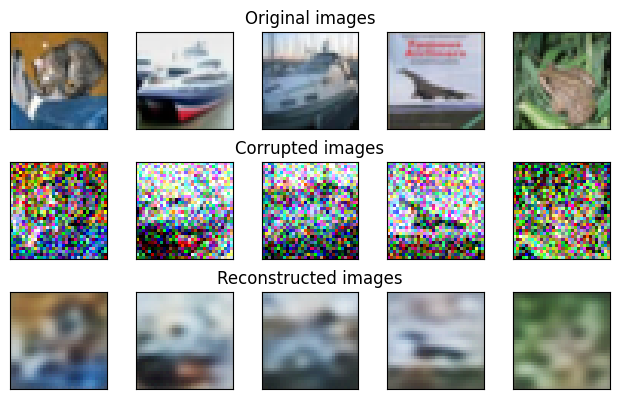

EPOCH 22/30
	 partial train loss (single batch): 0.064635
	 partial train loss (single batch): 0.064871
	 partial train loss (single batch): 0.064685
	 partial train loss (single batch): 0.065276
	 partial train loss (single batch): 0.064525
	 partial train loss (single batch): 0.065446
	 partial train loss (single batch): 0.064782
	 partial train loss (single batch): 0.064667
	 partial train loss (single batch): 0.064889
	 partial train loss (single batch): 0.065612
	 partial train loss (single batch): 0.065376
	 partial train loss (single batch): 0.064983
	 partial train loss (single batch): 0.065221
	 partial train loss (single batch): 0.065223
	 partial train loss (single batch): 0.065595
	 partial train loss (single batch): 0.064264
	 partial train loss (single batch): 0.064729
	 partial train loss (single batch): 0.064635
	 partial train loss (single batch): 0.065243
	 partial train loss (single batch): 0.064917
	 partial train loss (single batch): 0.064692
	 partial train loss (

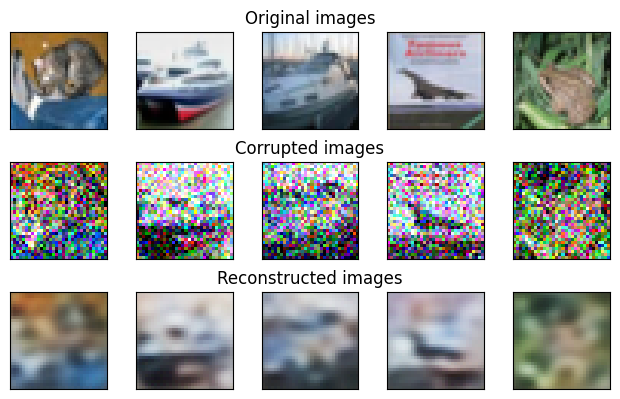

EPOCH 23/30
	 partial train loss (single batch): 0.064424
	 partial train loss (single batch): 0.064571
	 partial train loss (single batch): 0.064353
	 partial train loss (single batch): 0.064886
	 partial train loss (single batch): 0.064247
	 partial train loss (single batch): 0.065272
	 partial train loss (single batch): 0.064625
	 partial train loss (single batch): 0.064698
	 partial train loss (single batch): 0.064876
	 partial train loss (single batch): 0.065193
	 partial train loss (single batch): 0.065141
	 partial train loss (single batch): 0.064749
	 partial train loss (single batch): 0.065031
	 partial train loss (single batch): 0.065118
	 partial train loss (single batch): 0.065487
	 partial train loss (single batch): 0.064203
	 partial train loss (single batch): 0.064545
	 partial train loss (single batch): 0.064356
	 partial train loss (single batch): 0.064968
	 partial train loss (single batch): 0.064694
	 partial train loss (single batch): 0.064422
	 partial train loss (

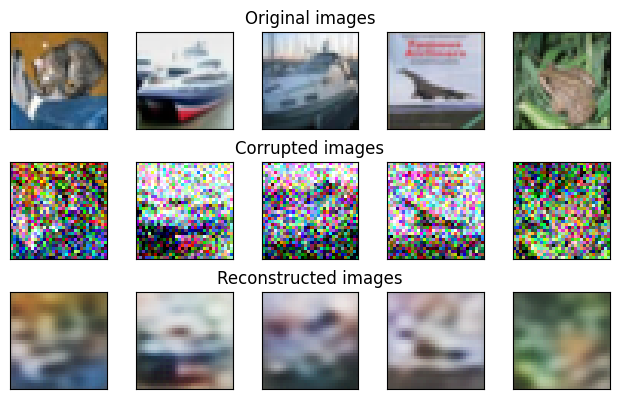

EPOCH 24/30
	 partial train loss (single batch): 0.064140
	 partial train loss (single batch): 0.064365
	 partial train loss (single batch): 0.064232
	 partial train loss (single batch): 0.064852
	 partial train loss (single batch): 0.064216
	 partial train loss (single batch): 0.065044
	 partial train loss (single batch): 0.064481
	 partial train loss (single batch): 0.064592
	 partial train loss (single batch): 0.064386
	 partial train loss (single batch): 0.065312
	 partial train loss (single batch): 0.065054
	 partial train loss (single batch): 0.064706
	 partial train loss (single batch): 0.064889
	 partial train loss (single batch): 0.065050
	 partial train loss (single batch): 0.065617
	 partial train loss (single batch): 0.064311
	 partial train loss (single batch): 0.064913
	 partial train loss (single batch): 0.064768
	 partial train loss (single batch): 0.065382
	 partial train loss (single batch): 0.065014
	 partial train loss (single batch): 0.064598
	 partial train loss (

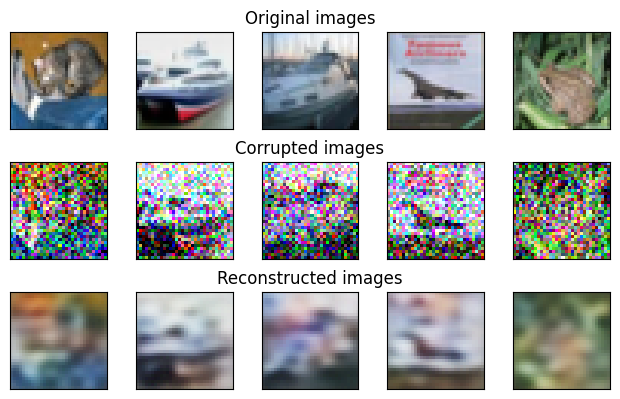

EPOCH 25/30
	 partial train loss (single batch): 0.064287
	 partial train loss (single batch): 0.064188
	 partial train loss (single batch): 0.064292
	 partial train loss (single batch): 0.064814
	 partial train loss (single batch): 0.063984
	 partial train loss (single batch): 0.064771
	 partial train loss (single batch): 0.064393
	 partial train loss (single batch): 0.064191
	 partial train loss (single batch): 0.064547
	 partial train loss (single batch): 0.065008
	 partial train loss (single batch): 0.064698
	 partial train loss (single batch): 0.064303
	 partial train loss (single batch): 0.064458
	 partial train loss (single batch): 0.064751
	 partial train loss (single batch): 0.065110
	 partial train loss (single batch): 0.063749
	 partial train loss (single batch): 0.064263
	 partial train loss (single batch): 0.063932
	 partial train loss (single batch): 0.064850
	 partial train loss (single batch): 0.064596
	 partial train loss (single batch): 0.064339
	 partial train loss (

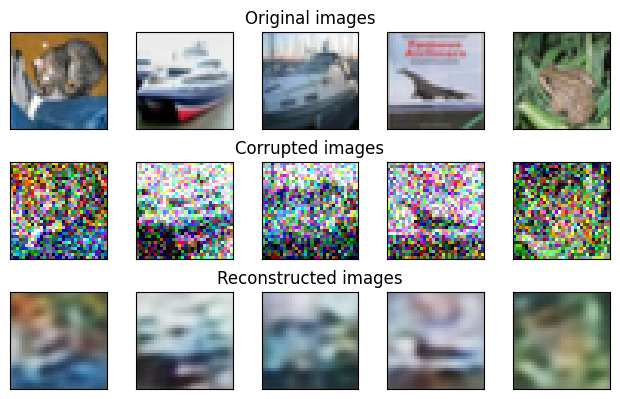

EPOCH 26/30
	 partial train loss (single batch): 0.064085
	 partial train loss (single batch): 0.064232
	 partial train loss (single batch): 0.064007
	 partial train loss (single batch): 0.064479
	 partial train loss (single batch): 0.063853
	 partial train loss (single batch): 0.064535
	 partial train loss (single batch): 0.064218
	 partial train loss (single batch): 0.064114
	 partial train loss (single batch): 0.064234
	 partial train loss (single batch): 0.064772
	 partial train loss (single batch): 0.064660
	 partial train loss (single batch): 0.064243
	 partial train loss (single batch): 0.064146
	 partial train loss (single batch): 0.064439
	 partial train loss (single batch): 0.064964
	 partial train loss (single batch): 0.063536
	 partial train loss (single batch): 0.064108
	 partial train loss (single batch): 0.063881
	 partial train loss (single batch): 0.064501
	 partial train loss (single batch): 0.064391
	 partial train loss (single batch): 0.064131
	 partial train loss (

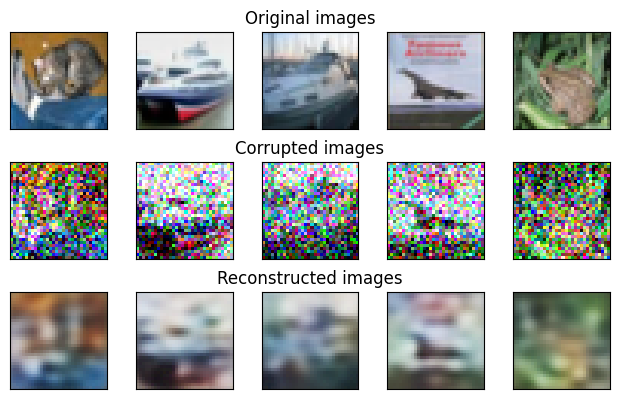

EPOCH 27/30
	 partial train loss (single batch): 0.063689
	 partial train loss (single batch): 0.063765
	 partial train loss (single batch): 0.063777
	 partial train loss (single batch): 0.064133
	 partial train loss (single batch): 0.063619
	 partial train loss (single batch): 0.064247
	 partial train loss (single batch): 0.063729
	 partial train loss (single batch): 0.064050
	 partial train loss (single batch): 0.064066
	 partial train loss (single batch): 0.064473
	 partial train loss (single batch): 0.064109
	 partial train loss (single batch): 0.063996
	 partial train loss (single batch): 0.064055
	 partial train loss (single batch): 0.064244
	 partial train loss (single batch): 0.064590
	 partial train loss (single batch): 0.063453
	 partial train loss (single batch): 0.063809
	 partial train loss (single batch): 0.063694
	 partial train loss (single batch): 0.064357
	 partial train loss (single batch): 0.064217
	 partial train loss (single batch): 0.064017
	 partial train loss (

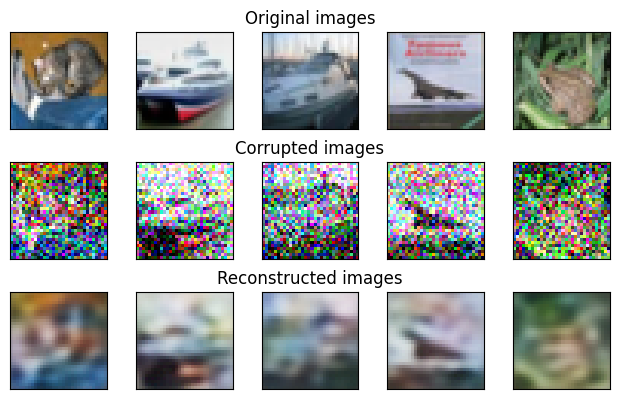

EPOCH 28/30
	 partial train loss (single batch): 0.063417
	 partial train loss (single batch): 0.063644
	 partial train loss (single batch): 0.063472
	 partial train loss (single batch): 0.064085
	 partial train loss (single batch): 0.063557
	 partial train loss (single batch): 0.064090
	 partial train loss (single batch): 0.063488
	 partial train loss (single batch): 0.063645
	 partial train loss (single batch): 0.063776
	 partial train loss (single batch): 0.064224
	 partial train loss (single batch): 0.064093
	 partial train loss (single batch): 0.063928
	 partial train loss (single batch): 0.063673
	 partial train loss (single batch): 0.063908
	 partial train loss (single batch): 0.064337
	 partial train loss (single batch): 0.063366
	 partial train loss (single batch): 0.063569
	 partial train loss (single batch): 0.063274
	 partial train loss (single batch): 0.064184
	 partial train loss (single batch): 0.063893
	 partial train loss (single batch): 0.063722
	 partial train loss (

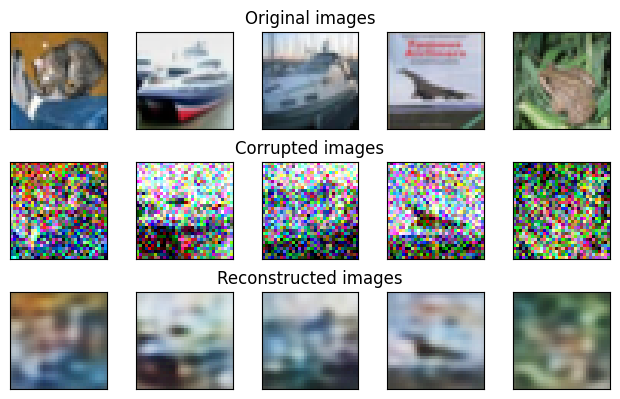

EPOCH 29/30
	 partial train loss (single batch): 0.063314
	 partial train loss (single batch): 0.063433
	 partial train loss (single batch): 0.063230
	 partial train loss (single batch): 0.063826
	 partial train loss (single batch): 0.063283
	 partial train loss (single batch): 0.063854
	 partial train loss (single batch): 0.063369
	 partial train loss (single batch): 0.063434
	 partial train loss (single batch): 0.063442
	 partial train loss (single batch): 0.064188
	 partial train loss (single batch): 0.063770
	 partial train loss (single batch): 0.063622
	 partial train loss (single batch): 0.063588
	 partial train loss (single batch): 0.063879
	 partial train loss (single batch): 0.064161
	 partial train loss (single batch): 0.063113
	 partial train loss (single batch): 0.063428
	 partial train loss (single batch): 0.062994
	 partial train loss (single batch): 0.063929
	 partial train loss (single batch): 0.063558
	 partial train loss (single batch): 0.063365
	 partial train loss (

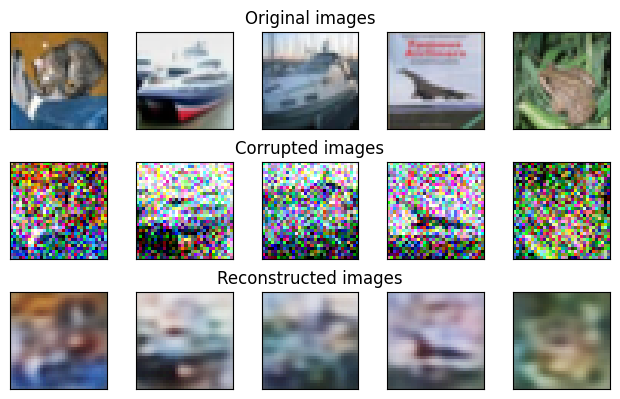

EPOCH 30/30
	 partial train loss (single batch): 0.063151
	 partial train loss (single batch): 0.063104
	 partial train loss (single batch): 0.063020
	 partial train loss (single batch): 0.063701
	 partial train loss (single batch): 0.063051
	 partial train loss (single batch): 0.063773
	 partial train loss (single batch): 0.063266
	 partial train loss (single batch): 0.063102
	 partial train loss (single batch): 0.063575
	 partial train loss (single batch): 0.063980
	 partial train loss (single batch): 0.063618
	 partial train loss (single batch): 0.063512
	 partial train loss (single batch): 0.063515
	 partial train loss (single batch): 0.063362
	 partial train loss (single batch): 0.064059
	 partial train loss (single batch): 0.062792
	 partial train loss (single batch): 0.063306
	 partial train loss (single batch): 0.062802
	 partial train loss (single batch): 0.063663
	 partial train loss (single batch): 0.063386
	 partial train loss (single batch): 0.063001
	 partial train loss (

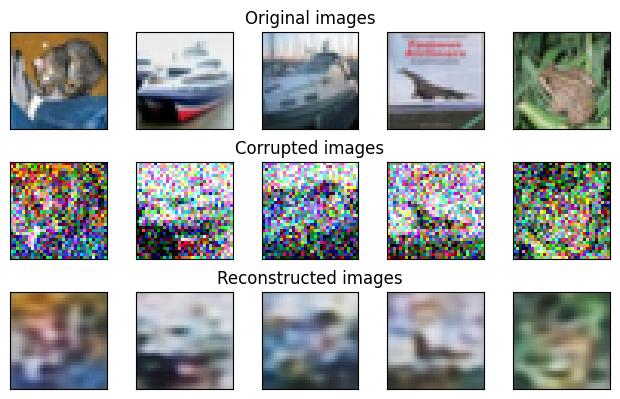

In [20]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


**Note that validation loss seems unusually lower than training loss!<br>
The reason is that training loss is progressively calculated for every image in the batch,<br>
whereas validation loss is calculated at the end of batch training, when the model performs best.**

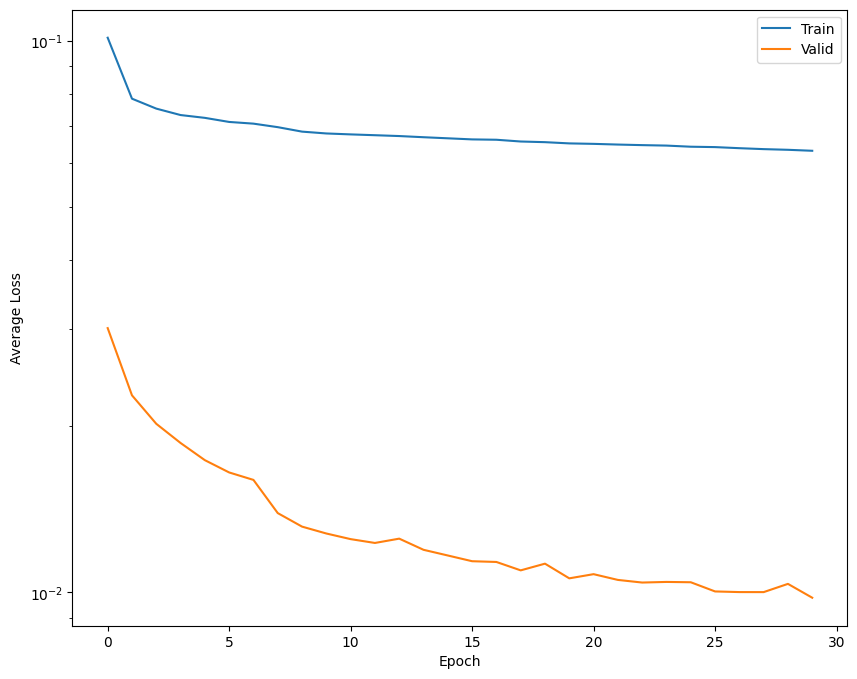

In [21]:
# Plot training performance
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history_da['train_loss'], label='Train')
plt.semilogy(history_da['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4 Visualize latent space

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1945.29it/s]


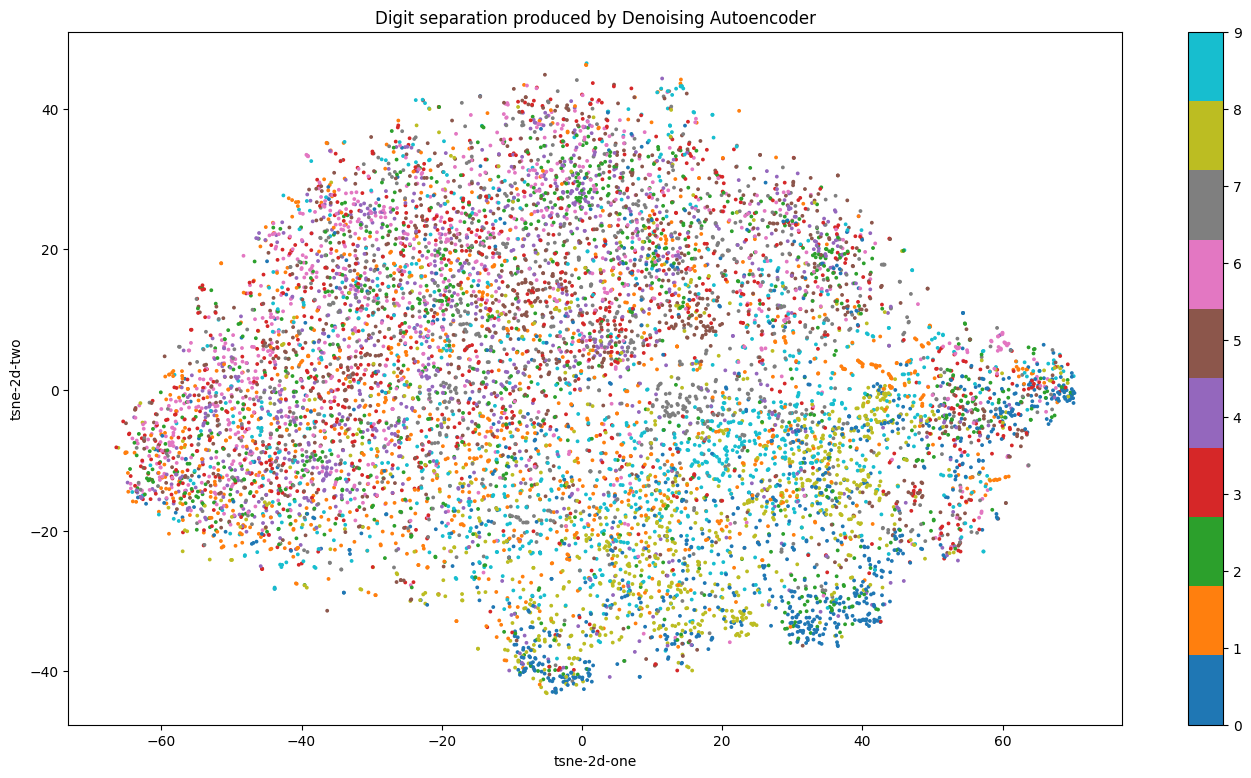

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


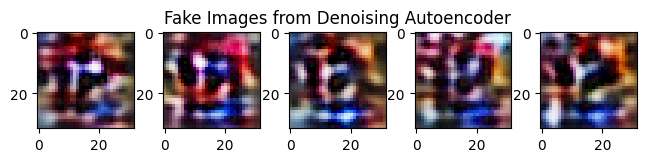

In [57]:
def plot_results(encoder, decoder, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    return
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

def plot_fakes(encoder, decoder, n, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    channels = 3
    latent_dim = d
    digit_size = 32
    
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        coords = [int(v*10) for v in np.random.rand(latent_dim)]
        # print(f'Vector from latent space: {coords}')
        z = torch.Tensor([coords]).to(device)
        x_hat = decoder(z)
        img = x_hat.reshape(channels, digit_size, digit_size).to('cpu').detach().numpy()

        ax = plt.subplot(3, n, i + 1 + n + n)
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        plt.imshow(img)  

        if i == n//2:
            ax.set_title(f'{model_name}')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   
    
plot_results(encoder, decoder, test_dataset, rx=(-1, 1), ry=(-1, 1), model_name="Denoising Autoencoder")
plot_fakes(encoder, decoder, n=5, rx=(-1, 1), ry=(-1, 1), model_name="Fake Images from Denoising Autoencoder")

In [58]:
import qiskit.tools.jupyter
%qiskit_version_table